In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels import PanelOLS


In [204]:
with open('sentiment_analysis.json', 'r') as outfile:
    sentiment = json.load(outfile)


In [205]:
dfs = []
for country in sentiment.keys():
    df_country = pd.DataFrame(sentiment[country])
    positive = df_country[0].apply(lambda x: x['label'] == 'POSITIVE')
    confidence = df_country[0].apply(lambda x: x['score'])
    date = pd.to_datetime(df_country[1])
    df_country = pd.concat(
        [positive, confidence, date, pd.Series([country]*len(df_country))], axis=1)
    df_country.columns = ['positive', 'confidence', 'date', 'country']
    dfs.append(df_country)

df_sentiment = pd.concat(dfs)


In [206]:
df_sentiment.head()


,positive,confidence,date,country
0,False,0.986878,2022-06-01,Afghanistan
1,False,0.973780,2022-06-01,Afghanistan
2,False,0.985382,2022-06-01,Afghanistan
3,True,0.999858,2022-05-31,Afghanistan
4,True,0.994505,2022-05-31,Afghanistan


In [207]:
start_date = pd.to_datetime("2008-01-01")
end_date = pd.to_datetime("2022-06-01")
n_months = (end_date.year - start_date.year) * \
    12 + (end_date.month - start_date.month)
bins = [start_date + pd.DateOffset(months=i) for i in range(n_months + 1)]


In [208]:
cuts = pd.cut(df_sentiment['date'], bins)
df_sentiment_grouped = df_sentiment.groupby(['country', cuts])
df_mean_sentiment = df_sentiment_grouped.mean()
df_count_sentiment = df_sentiment_grouped['positive'].count().rename('count')
df_sentiment_panel = pd.concat([df_mean_sentiment, df_count_sentiment], axis=1)
df_sentiment_panel['date'] = list(
    map(lambda x: x.right, df_mean_sentiment.index.get_level_values(1)))


In [209]:
df_sentiment_panel = df_sentiment_panel.droplevel(1).reset_index()


In [210]:
df_sentiment_panel.head()


,country,positive,confidence,count,date
0,Afghanistan,0.447619,0.945782,210,2008-02-01
1,Afghanistan,0.407143,0.950797,280,2008-03-01
2,Afghanistan,0.411538,0.952065,260,2008-04-01
3,Afghanistan,0.452055,0.930062,219,2008-05-01
4,Afghanistan,0.364130,0.947841,184,2008-06-01


In [211]:
df_world_crisis = pd.read_csv('predicting_food_crises_data.csv')
mask = ~df_world_crisis['fews_ipc'].isna()
df_world_crisis['date'] = pd.to_datetime(
    df_world_crisis['year_month'], format="%Y_%m")


In [212]:
def f(x):
    total_pop = x['pop'].sum()
    crisis = x['fews_ipc'] >= 2.9
    return np.sum(crisis * x['pop'])/total_pop


df_world_crisis_grouped = df_world_crisis[mask].groupby(
    ['country', 'date']).apply(f)


In [213]:
def f(x):
    total_pop = x['pop'].sum()
    crisis = x['fews_proj_near'] >= 2.9
    return np.sum(crisis * x['pop'])/total_pop


dfl = df_world_crisis[mask].groupby(['country', 'date']).apply(f)


In [214]:
def f(x):
    total_pop = x['pop'].sum()
    crisis = x['fews_ipc'] >= 2.9
    return np.sum(crisis * x['pop'])/total_pop


df_world_crisis_grouped = df_world_crisis[mask].groupby(
    ['country', 'date']).apply(f)


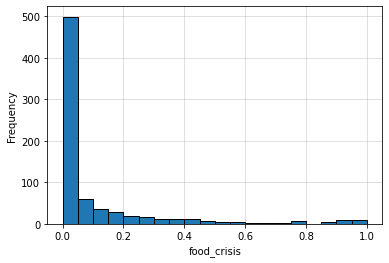

In [215]:
fig, ax = plt.subplots()
df_world_crisis_grouped.plot(kind='hist', bins=20, ax=ax, edgecolor='black')
ax.grid(alpha=0.5)
ax.set_axisbelow(True)
ax.set_xlabel('food_crisis')

plt.savefig('food_crisis_dist.pdf', format='pdf')


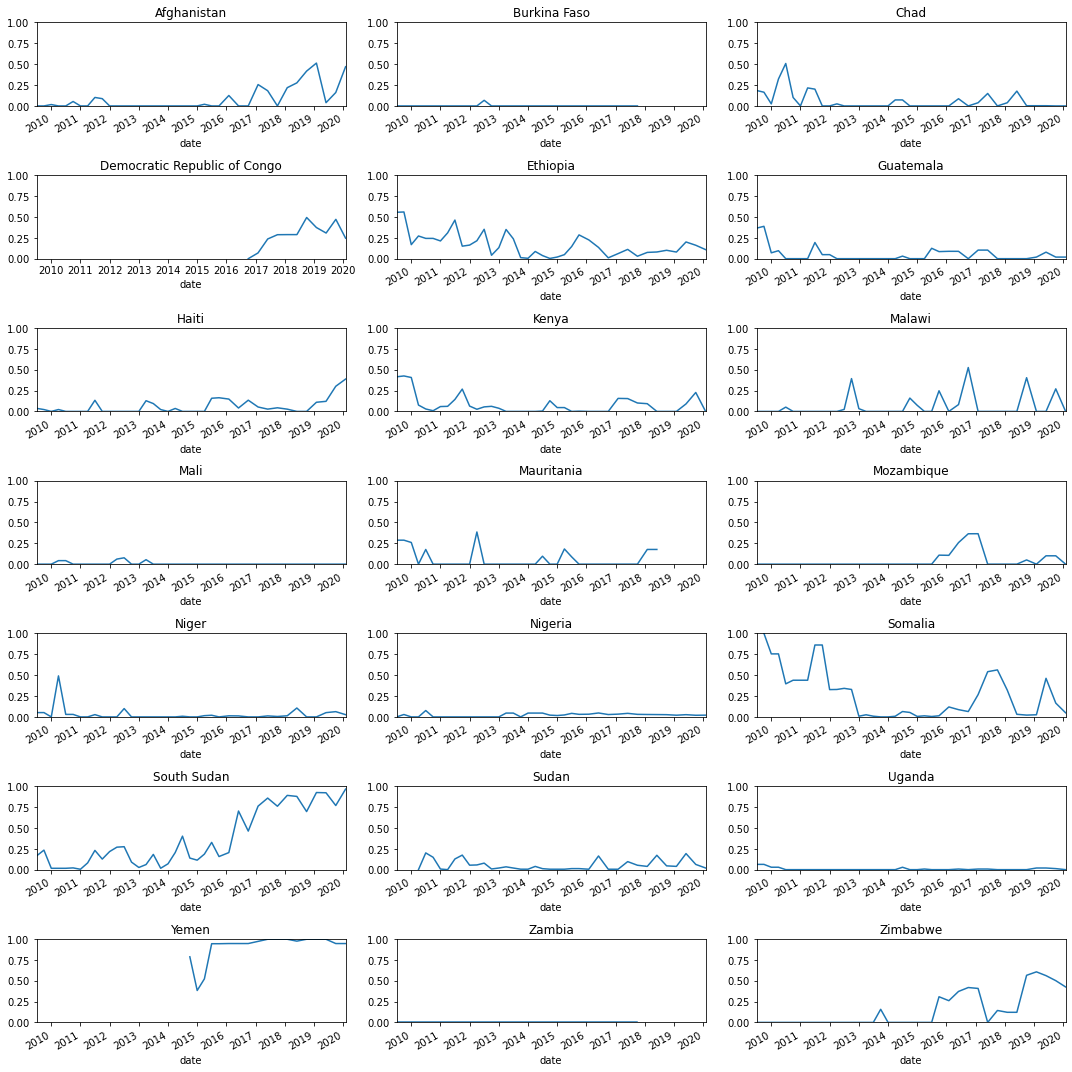

In [218]:
df_g = df_world_crisis_grouped.sort_index().groupby('country')
min_date = df_world_crisis_grouped.reset_index()['date'].min()
max_date = df_world_crisis_grouped.reset_index()['date'].max()
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15, 15))
axs = axs.flatten()
i = 0
for country, df in df_g:
    df.droplevel('country').plot(ax=axs.flatten()[i])
    axs[i].set_title(country)
    axs[i].set_ylim(0, 1)
    axs[i].set_xlim(min_date, max_date)
    axs[i].tick_params(axis='x', which='minor', bottom=False)

    i += 1
plt.minorticks_off()
plt.tight_layout()
plt.savefig("food_crisis_per_country.pdf", format="pdf")


In [219]:
print(pd.DataFrame(df_sentiment_panel.groupby('country')
      ['count'].sum().sort_values()).to_latex())


\begin{tabular}{lr}
\toprule
{} &  count \\
country                  &        \\
\midrule
Djibouti                 &    465 \\
Eswatini                 &    511 \\
Lesotho                  &    553 \\
Mauritania               &    660 \\
Burundi                  &    908 \\
Burkina Faso             &   1157 \\
Namibia                  &   1404 \\
Madagascar               &   1423 \\
Angola                   &   1714 \\
Mozambique               &   1823 \\
Zambia                   &   1931 \\
Niger                    &   1942 \\
Malawi                   &   1981 \\
Guatemala                &   2005 \\
Honduras                 &   2364 \\
Mali                     &   3017 \\
Chad                     &   3126 \\
Tanzania                 &   3241 \\
Haiti                    &   3252 \\
Ethiopia                 &   4717 \\
Somalia                  &   4980 \\
Uganda                   &   5615 \\
Congo                    &   5856 \\
Zimbabwe                 &   6076 \\
Sudan                 

In [229]:
# Creating the data, for each country at each date that the IPC is available we
# find the average IPC phase 3+ percentage, sentiment, normalized articles published, lagged IPC phase 3+ percentage,
# and near ter projections using boolean masking.

lag = 4
size = 3
count_means = df_sentiment_panel.groupby('country').mean()['count']
data = []
for idx, val in df_world_crisis_grouped.iteritems():
    country = idx[0]
    if country == 'Democratic Republic of Congo':
        country = 'Congo'
    date = idx[1]
    mask = (df_sentiment_panel['country'] == country) & (df_sentiment_panel['date'] <= date - pd.DateOffset(
        months=lag)) & (df_sentiment_panel['date'] >= date - pd.DateOffset(months=lag) - pd.DateOffset(months=size-1))
    data.append([df_sentiment_panel[mask]['positive'].mean(
    ), df_sentiment_panel[mask]['count'].mean()/count_means[country], val, country, date])

    # adding the lagged average IPC phase 3+ percentages
    mask = (df_world_crisis_grouped.reset_index()['country'] == idx[0]) & (df_world_crisis_grouped.reset_index()['date'] <= date - pd.DateOffset(
        months=lag)) & (df_world_crisis_grouped.reset_index()['date'] >= date - pd.DateOffset(months=lag) - pd.DateOffset(months=size))
    data[-1].append(df_world_crisis_grouped.reset_index()[mask][0].mean())
    # adding the average IPC phase 3+ percentages near term projections
    mask = (dfl.reset_index()['country'] == idx[0]) & (dfl.reset_index()['date'] <= date - pd.DateOffset(
        months=lag)) & (dfl.reset_index()['date'] >= date - pd.DateOffset(months=lag) - pd.DateOffset(months=size))
    data[-1].append(dfl.reset_index()[mask][0].mean())


In [233]:
X_df = pd.DataFrame(data).dropna()
X = X_df.rename({0: 'positive_sentiment', 1: 'articles_published', 2: 'perc_crisis',
                3: 'country', 4: 'date', 5: 'lagged_perc_crises', 6: 'proj_near'}, axis=1)
X = X.set_index(['country', 'date'])
y = X['perc_crisis']
X = X.drop('perc_crisis', axis=1)


In [234]:
reg = PanelOLS(y, X, entity_effects=True).fit()
reg.summary


Dep. Variable:,perc_crisis,R-squared:,0.3772
Estimator:,PanelOLS,R-squared (Between):,0.6759
No. Observations:,704,R-squared (Within):,0.3772
Date:,"Fri, Aug 19 2022",R-squared (Overall):,0.5066
Time:,13:17:18,Log-likelihood,600.43
Cov. Estimator:,Unadjusted,,
,,F-statistic:,102.82
Entities:,21,P-value,0.0000
Avg Obs:,33.524,Distribution:,"F(4,679)"
Min Obs:,10.0000,,
Max Obs:,37.000,F-statistic (robust):,102.82


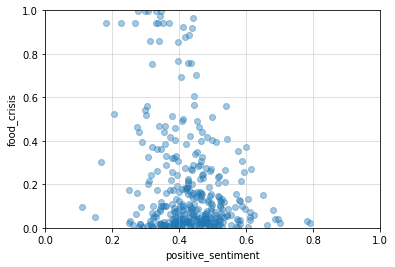

In [236]:
fig, ax = plt.subplots()
ax.scatter(X.iloc[:, 0], y, alpha=0.4)
ax.set_xlabel('positive_sentiment')
ax.set_ylabel('food_crisis')
ax.grid(alpha=.5)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
fig.savefig("scatterplot_food_crisis_sentiment.pdf", format="pdf")


In [237]:
mask = y > 0
X = X[mask]
y = y[mask]

reg = PanelOLS(y, X, entity_effects=True).fit()
reg.summary


Dep. Variable:,perc_crisis,R-squared:,0.4050
Estimator:,PanelOLS,R-squared (Between):,0.3846
No. Observations:,354,R-squared (Within):,0.4050
Date:,"Fri, Aug 19 2022",R-squared (Overall):,0.4018
Time:,13:18:08,Log-likelihood,234.30
Cov. Estimator:,Unadjusted,,
,,F-statistic:,56.164
Entities:,21,P-value,0.0000
Avg Obs:,16.857,Distribution:,"F(4,330)"
Min Obs:,0.0000,,
Max Obs:,37.000,F-statistic (robust):,56.164


In [238]:
corrs = []
for lag in range(0, 13):
    size = 3
    count_means = df_sentiment_panel.groupby('country').mean()['count']
    data = []
    for idx, val in df_world_crisis_grouped.iteritems():
        country = idx[0]
        if country == 'Democratic Republic of Congo':
            country = 'Congo'
        date = idx[1]
        mask = (df_sentiment_panel['country'] == country) & (df_sentiment_panel['date'] <= date - pd.DateOffset(
            months=lag)) & (df_sentiment_panel['date'] >= date - pd.DateOffset(months=lag) - pd.DateOffset(months=size-1))
        data.append([df_sentiment_panel[mask]['positive'].mean(
        ), df_sentiment_panel[mask]['count'].mean()/count_means[country], val, country, date])
    df_t = pd.DataFrame(data).iloc[:, [0, 2, 3]].groupby(3)
    mask = df_t.corr() != 1
    corrs.append(df_t.corr()[mask].mean())


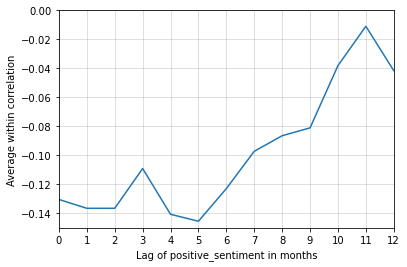

In [239]:
fig, ax = plt.subplots()

ax.plot([corrs[i][0]for i in range(len(corrs))])
ax.set_xticks(range(0, 13))
ax.set_ylim(-0.15, 0)
ax.set_xlim(0, 12)
ax.grid(alpha=0.5)
ax.set_xlabel("Lag of positive_sentiment in months")
ax.set_ylabel("Average within correlation")

fig.savefig("correlation_over_time.pdf", format="pdf")
